# GCN
\
スカラー形式の式
$$ \pmb{h}_v^{(l+1)} = \sum_{u \in \mathcal{N}(v)} \frac{1}{\sqrt{\deg(v)} \sqrt{\deg(u)}} \left( \mathbf{W}^{(l+1)} \pmb{h}_u^{(l)} \right) + \pmb{b} $$
行列形式の式
$$
H^{(l+1)} = \sigma \left( \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} H^{(l)} W^{(l+1)} \right)
$$

参考文献 :\
佐藤竜馬: 「機械学習プロフェッショナルシリーズ グラフニューラルネットワーク」 \
村田剛志: 「グラフニューラルネットワーク PyTorchによる実装」 \
「PyG」 \
https://pytorch-geometric.readthedocs.io/en/latest/index.html \
「SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS」 \
https://arxiv.org/pdf/1609.02907 \
「PyTorch実装で理解するGraph Convolutional Network」 \
https://zenn.dev/hash_yuki/articles/cb008a7c19e917 \
「Demystifying GCNs: A Step-by-Step Guide to Building a Graph Convolutional Network Layer in PyTorch」 \
https://medium.com/@jrosseruk/demystifying-gcns-a-step-by-step-guide-to-building-a-graph-convolutional-network-layer-in-pytorch-09bf2e788a51 \
「【PyG】PyTorch Geometricのインストール方法から利用方法まで解説」 \
https://disassemble-channel.com/how-to-use-pyg-pytorch-geometric

目的 : \
Graph Convolutional Networks の基礎理解と実装を行う。

# インポート

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

from sklearn.manifold import TSNE

from typing import Any, List, Optional, Tuple

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# デバイスの確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 基本的な実装

今回は、5個のノード $ V = \{v_0, v_1, v_2, v_3, v_4\} $ を持つ無向グラフを考える。\
ノード特徴量行列 $ X $ を作成する。4次元の特徴量をランダムに生成する。

(5, 4)
[[2.76405235 1.40015721 1.97873798 3.2408932 ]
 [2.86755799 0.02272212 1.95008842 0.84864279]
 [0.89678115 1.4105985  1.14404357 2.45427351]
 [1.76103773 1.12167502 1.44386323 1.33367433]
 [2.49407907 0.79484174 1.3130677  0.14590426]]


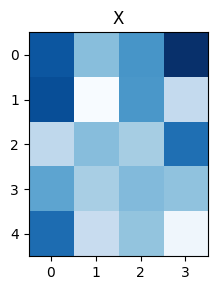

In [3]:
num_node = 5 # ノード数
in_channels = 4 # ノード特徴量の次元数
np.random.seed(0) # 乱数固定
X = np.random.randn(num_node, in_channels) + 1 # ノード特徴量行列の生成（数値はランダム）

# ヒートマップのプロット関数
def plot_heatmap(**matrices):
    num_plots = len(matrices)
    fig, axes = plt.subplots(1, num_plots, figsize=(4*num_plots, 3))
    if num_plots == 1:
        axes = [axes]

    for i, (name, matrix) in enumerate(matrices.items()):
        axes[i].imshow(matrix, cmap='Blues', aspect='equal')
        axes[i].set_title(name)

    plt.tight_layout()
    plt.show()

print(X.shape)
print(X)
plot_heatmap(X=X)

エッジ集合 $ E $ を作成する。 \
GCN は各頂点に自己ループを追加する。

In [4]:
E = [[0, 1], [0, 2], [1, 2], [1, 3], [1, 4], [2, 3]] # エッジの作成
reversed_E = [[j, i] for [i, j] in E] # 無向グラフなので、逆向きのエッジを作成
I = [[i, i] for i in range(num_node)] # GCNは自己ループを追加する

new_E = E + reversed_E  + I # 足し合わせる
print(new_E)

[[0, 1], [0, 2], [1, 2], [1, 3], [1, 4], [2, 3], [1, 0], [2, 0], [2, 1], [3, 1], [4, 1], [3, 2], [0, 0], [1, 1], [2, 2], [3, 3], [4, 4]]


隣接行列 $ A $ を作成する。 \
自己ループを組み込んだ隣接行列であるため、変数名は A_tilde とする。

(5, 5)
[[1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 1. 0. 0. 1.]]


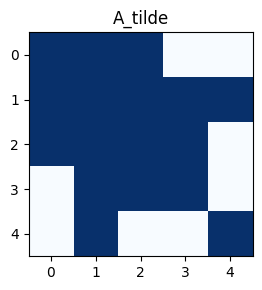

In [5]:
# エッジから隣接行列を作成する関数
def edge2mat(E, num_node):
    A = np.zeros((num_node, num_node))
    for i, j in E:
        A[i, j] = 1
    return A

A_tilde = edge2mat(new_E, num_node)

print(A_tilde.shape)
print(A_tilde)
plot_heatmap(A_tilde=A_tilde)

隣接行列 $ A $ と ノード特徴量行列 $ X $ の内積を取ることで、近傍ノードを反映した新たなノード特徴量行列が得られる。

X : 
[[2.76405235 1.40015721 1.97873798 3.2408932 ]
 [2.86755799 0.02272212 1.95008842 0.84864279]
 [0.89678115 1.4105985  1.14404357 2.45427351]
 [1.76103773 1.12167502 1.44386323 1.33367433]
 [2.49407907 0.79484174 1.3130677  0.14590426]]
new_X : 
[[ 6.52839148  2.83347783  5.07286997  6.5438095 ]
 [10.78350828  4.74999458  7.82980091  8.02338809]
 [ 8.28942921  3.95515285  6.51673321  7.87748383]
 [ 5.52537686  2.55499564  4.53799522  4.63659063]
 [ 5.36163706  0.81756386  3.26315612  0.99454705]]


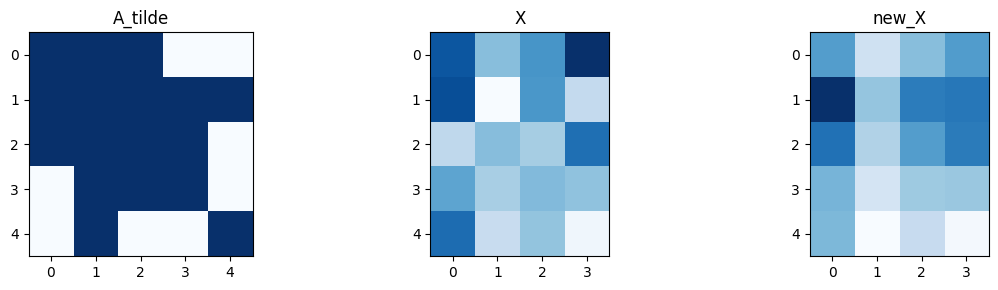

In [6]:
new_X = A_tilde @ X
print(f'X : \n{X}')
print(f'new_X : \n{new_X}')
plot_heatmap(A_tilde=A_tilde, X=X, new_X=new_X)

しかし、これでは近傍の数が多いノードほど特徴量値が爆発的に高くなってしまう。 \
今回の例では、$ v_2 $ の隣接ノードが一番多く、元の特徴量値に関係なく更新した特徴量値が大きくなっている。 \
\
そこで、近傍ノード数の平方根で正規化 $ \frac{1}{\sqrt{|\mathcal{N}(v)|}} $ を行う。 \
さらに、近傍ノードの近傍ノード数の平方根で正規化 $ \frac{1}{\sqrt{|\mathcal{N}(u) \mid  u \in \mathcal{N}(v)|}} $ を行うことで、行と列に与える影響を対象にすることができる。 \
整理すると、以下の式になる。
$$
\sum_{u \in \mathcal{N}(v)} \frac{1}{\sqrt{|\mathcal{N}(v)|} \sqrt{|\mathcal{N}(u)|}} \pmb{x}_u
$$
\
これを行列計算の式に直すには、次数行列 $ D $ の逆行列の平方根 $ D^{- \frac{1}{2}} $ が必要になる。

[[0.57735027 0.         0.         0.         0.        ]
 [0.         0.4472136  0.         0.         0.        ]
 [0.         0.         0.5        0.         0.        ]
 [0.         0.         0.         0.57735027 0.        ]
 [0.         0.         0.         0.         0.70710678]]


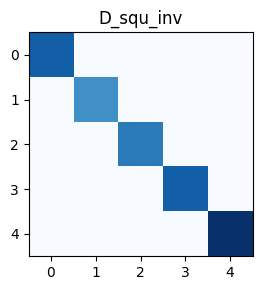

In [7]:
def get_D(A, pow=-0.5):
    D = np.zeros_like(A)
    d_ii = np.sum(A, 0)
    for i in range(len(A)):
        D[i,i] = d_ii[i] ** pow
    return D

D_squ_inv = get_D(A_tilde)
print(D_squ_inv)
plot_heatmap(D_squ_inv=D_squ_inv)

先ほどの整理した正規化の式を行列計算の形に直すと、 $ D^{- \frac{1}{2}} A D^{- \frac{1}{2}} $ となる。 \
正規化された隣接行列は $\hat A$ とする。

A_hat :
 [[0.33333333 0.25819889 0.28867513 0.         0.        ]
 [0.25819889 0.2        0.2236068  0.25819889 0.31622777]
 [0.28867513 0.2236068  0.25       0.28867513 0.        ]
 [0.         0.25819889 0.28867513 0.33333333 0.        ]
 [0.         0.31622777 0.         0.         0.5       ]]


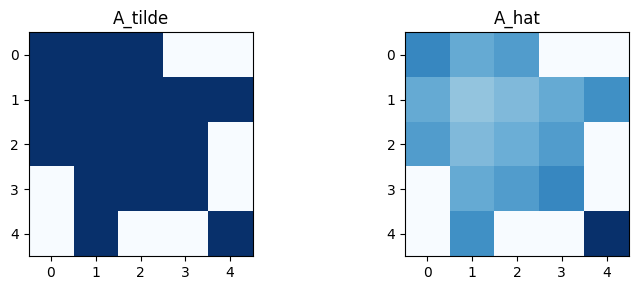

In [8]:
A_hat = D_squ_inv @ A_tilde @ D_squ_inv
print(f'A_hat :\n {A_hat}')
plot_heatmap(A_tilde=A_tilde, A_hat=A_hat)

$ \hat A $ と $X$ の内積を取ることで、近傍ノード数が大きくても新たな特徴量値が爆発せずに集約できる。

new_X :
 [[ 6.52839148  2.83347783  5.07286997  6.5438095 ]
 [10.78350828  4.74999458  7.82980091  8.02338809]
 [ 8.28942921  3.95515285  6.51673321  7.87748383]
 [ 5.52537686  2.55499564  4.53799522  4.63659063]
 [ 5.36163706  0.81756386  3.26315612  0.99454705]]
norm_new_X :
 [[1.92062949 0.87979061 1.49334692 2.00790409]
 [2.73110824 1.22244915 1.9447739  1.94580803]
 [2.17168173 1.0857207  1.71008379 2.12389457]
 [1.58629128 0.78696321 1.31505534 1.37216447]
 [2.15384099 0.40460623 1.27320595 0.34131654]]


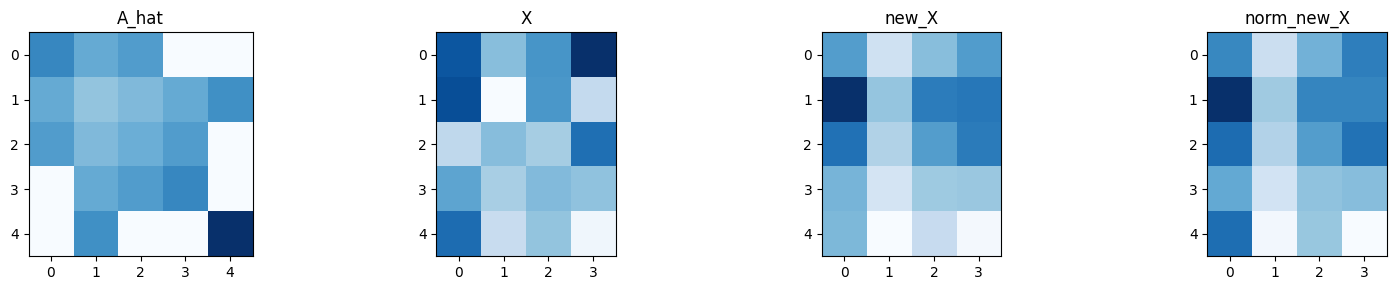

In [9]:
norm_new_X = A_hat @ X
print(f'new_X :\n {new_X}')
print(f'norm_new_X :\n {norm_new_X}')
plot_heatmap(A_hat=A_hat, X=X, new_X=new_X, norm_new_X=norm_new_X)

学習によって新たな特徴量値を得るために、パラメータ行列 $W$ を用意する。$W$ の列数が新たな特徴量の次元数となる。 \
ReLU関数などの非線形性を追加した数式以下になる。
$$
\sigma (\hat A X W)
$$

#  PyG を使用した実装

ここからは PyG を使用して GCN の実装を行う。 \
まずは、先ほどの無向グラフをPyGに入力するデータに変換する。

In [10]:
new_E = np.array(new_E).T # PyG は [[出発ノード],[終着ノード]] でエッジを管理するので転置を取る
edge_index = torch.tensor(new_E, dtype=torch.long) # テンソルに変換する
print(f"2 * num_edge のエッジの配列 : \n{edge_index}")
features = torch.tensor(X) # テンソルに変換する
print(f"ノードの特徴量 : \n{features}")
labels = torch.tensor([0, 1, 2, 1, 1], dtype=torch.float) # テンソルに変換する
print(f"ノードのラベル : \n{labels}")
data = Data(x=features, y=labels, edge_index=edge_index) # Dataクラスは PyG のグラフ構造を扱うための基本的なデータコンテナ
print(f"グラフの簡易情報 : \n{data}")

2 * num_edge のエッジの配列 : 
tensor([[0, 0, 1, 1, 1, 2, 1, 2, 2, 3, 4, 3, 0, 1, 2, 3, 4],
        [1, 2, 2, 3, 4, 3, 0, 0, 1, 1, 1, 2, 0, 1, 2, 3, 4]])
ノードの特徴量 : 
tensor([[2.7641, 1.4002, 1.9787, 3.2409],
        [2.8676, 0.0227, 1.9501, 0.8486],
        [0.8968, 1.4106, 1.1440, 2.4543],
        [1.7610, 1.1217, 1.4439, 1.3337],
        [2.4941, 0.7948, 1.3131, 0.1459]], dtype=torch.float64)
ノードのラベル : 
tensor([0., 1., 2., 1., 1.])
グラフの簡易情報 : 
Data(x=[5, 4], edge_index=[2, 17], y=[5])


Network X で描画する。 クラスごとにノードの色を変えている。

In [11]:
data.x.numpy()

array([[2.76405235, 1.40015721, 1.97873798, 3.2408932 ],
       [2.86755799, 0.02272212, 1.95008842, 0.84864279],
       [0.89678115, 1.4105985 , 1.14404357, 2.45427351],
       [1.76103773, 1.12167502, 1.44386323, 1.33367433],
       [2.49407907, 0.79484174, 1.3130677 , 0.14590426]])

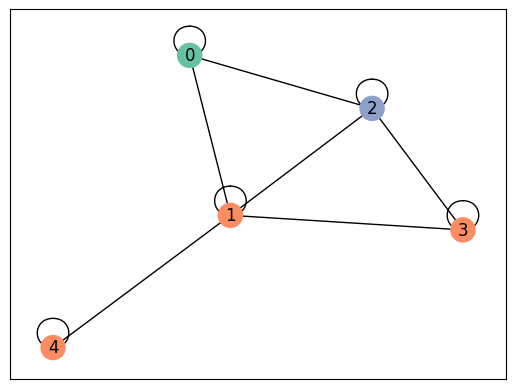

In [12]:
# PyG グラフデータをクラスラベルつきNetworkX 描画をする関数
def visualize_graph(G):
    unique_classes = list(set(G.y.tolist()))
    colormap = plt.colormaps.get_cmap('Set2')
    class_to_color = {cls: colormap(i) for i, cls in enumerate(unique_classes)}
    node_colors = [class_to_color[int(G.y[i].item())] for i in range(G.num_nodes)]

    nxg = to_networkx(G,
                      to_undirected=True
                      )
    nx.draw_networkx(nxg, with_labels=True, node_color=node_colors)

visualize_graph(data)

ここからは、PyG に搭載されているグラフデータを使用して実装していく。 \
PyG 搭載されたデータセットを見てみる。

In [13]:
# torchvison.datasets の PyG 版である torch_geometric.datasets
# どんなデータがあるのかを見てみる。
from torch_geometric import datasets
dir(datasets)

['AMiner',
 'AQSOL',
 'Actor',
 'AirfRANS',
 'Airports',
 'Amazon',
 'AmazonBook',
 'AmazonProducts',
 'AttributedGraphDataset',
 'BA2MotifDataset',
 'BAMultiShapesDataset',
 'BAShapes',
 'BitcoinOTC',
 'BrcaTcga',
 'CitationFull',
 'CoMA',
 'Coauthor',
 'CoraFull',
 'CornellTemporalHyperGraphDataset',
 'DBLP',
 'DBP15K',
 'DGraphFin',
 'DeezerEurope',
 'DynamicFAUST',
 'EllipticBitcoinDataset',
 'EllipticBitcoinTemporalDataset',
 'EmailEUCore',
 'Entities',
 'ExplainerDataset',
 'FAUST',
 'FB15k_237',
 'FacebookPagePage',
 'FakeDataset',
 'FakeHeteroDataset',
 'Flickr',
 'GDELT',
 'GDELTLite',
 'GEDDataset',
 'GNNBenchmarkDataset',
 'GemsecDeezer',
 'GeometricShapes',
 'GitHub',
 'HGBDataset',
 'HM',
 'HeterophilousGraphDataset',
 'HydroNet',
 'ICEWS18',
 'IGMCDataset',
 'IMDB',
 'InfectionDataset',
 'JODIEDataset',
 'KarateClub',
 'LINKXDataset',
 'LRGBDataset',
 'LastFM',
 'LastFMAsia',
 'MD17',
 'MNISTSuperpixels',
 'MalNetTiny',
 'MixHopSyntheticDataset',
 'ModelNet',
 'MoleculeNe

## KarateClub データ

今回は簡単な KarateClub を使用する。

In [14]:
# KarateClubデータセットの読み込みと情報の表示
dataset = datasets.KarateClub()
print(f"Dataset : {dataset}")
print("=" * 30)
print(f"グラフの数 : {len(dataset)}")
print(f"ノード特徴量の次元数 : {dataset.num_node_features}")
print(f"クラス数 : {dataset.num_classes}")
print("=" * 30)
data = dataset[0] # 最初のグラフを取り出す。(今回はグラフの数は1つなので全部である。)
print(data) # x = [ノード数, 特徴量次元数], edge_index = [エッジの端点数2 (ノードa -> b的な), エッジの数], y = [正解データが格納されてる], train_mask = どのノードを訓練データにするかの配列
print(data.train_mask) # train_maskを見てみる。 -> 0, 4, 8, 24 のノードが訓練データとして使用されるらしい。
print("=" * 30)
print(f"ノードの数 : {data.num_nodes}")
print(f"エッジの数 : {data.num_edges}")
print(f"訓練に使うノードの数 : {data.train_mask.sum()}")
print(f"孤立したノードが存在するか : {data.has_isolated_nodes()}")
print(f"自己ループはあるか : {data.has_self_loops()}")
print(f"無向グラフか : {data.is_undirected()}")

Dataset : KarateClub()
グラフの数 : 1
ノード特徴量の次元数 : 34
クラス数 : 4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])
ノードの数 : 34
エッジの数 : 156
訓練に使うノードの数 : 4
孤立したノードが存在するか : False
自己ループはあるか : False
無向グラフか : True


Network X で表示してみる。 \
今回から、t-sne を使用して類似した特徴量を持つノードの位置を近くなるようにプロットする。

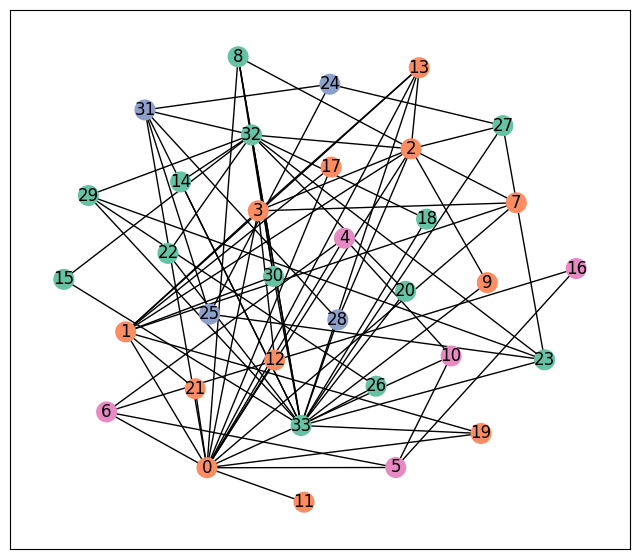

In [15]:
# 特徴量を使ってノード同士の近さを反映するために t-sne による次元削減の追加
def visualize_graph(G,
                    with_labels=True,
                    node_size=200,
                    edge_color='k',
                    width=1.0
                    ):
    unique_classes = list(set(G.y.tolist()))
    colormap = plt.colormaps.get_cmap('Set2')
    class_to_color = {cls: colormap(i) for i, cls in enumerate(unique_classes)}
    node_colors = [class_to_color[int(G.y[i].item())] for i in range(G.num_nodes)]

    emb = G.x.numpy()
    tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate="auto")
    emb_tsne = tsne.fit_transform(emb)
    fig, ax = plt.subplots(figsize=(8, 7))
    nxg = to_networkx(G, to_undirected=True)
    nx.draw_networkx(nxg, ax=ax, pos=emb_tsne, node_color=node_colors, with_labels=with_labels, node_size=node_size, edge_color=edge_color, width=width)
    plt.show()


visualize_graph(data)

モデルを組む

In [16]:
# グラフ畳み込みネットワークの定義
class GCN(torch.nn.Module):
    def __init__(self, in_d, mid_d, out_d):
        super().__init__()
        # 必要引数は Conv2d と一緒。入力次元(チャネル)と出力次元。
        # karateデータは自己ループがないので追加。normalize=True によってデフォルト設定で自己ループがないときは自動的に追加される
        self.conv1 = GCNConv(in_d, mid_d)
        self.conv2 = GCNConv(mid_d, out_d)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index # PyTorch と異なり、ノードデータとエッジデータを取得する

        x = self.conv1(x, edge_index)
        emb = x.detach()
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return x, emb

In [17]:
in_d = dataset.num_node_features
out_d = dataset.num_classes

net = GCN(in_d, 16, out_d).to(device)
print(net)

GCN(
  (conv1): GCNConv(34, 16)
  (conv2): GCNConv(16, 4)
)


学習を行う(& プロットするために t-sne による次元削減)

Epoch: 100 
 Train loss: 0.9875680208206177


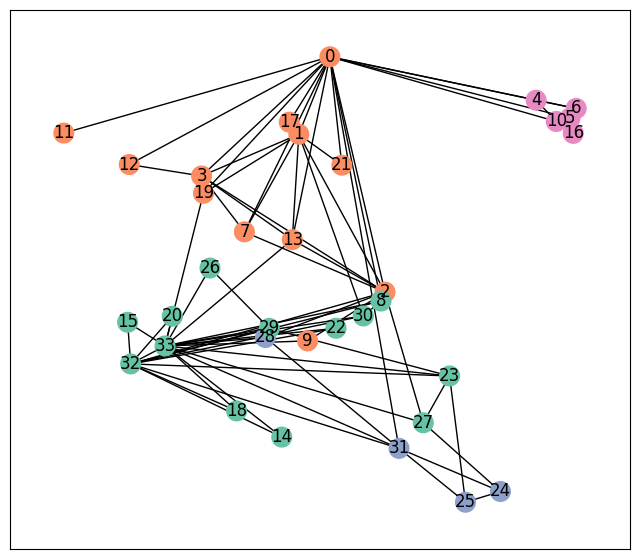

Epoch: 200 
 Train loss: 0.632523775100708


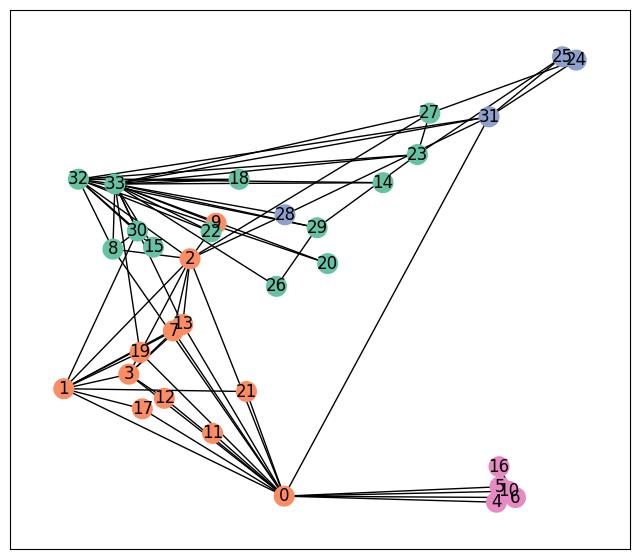

Epoch: 300 
 Train loss: 0.34796470403671265


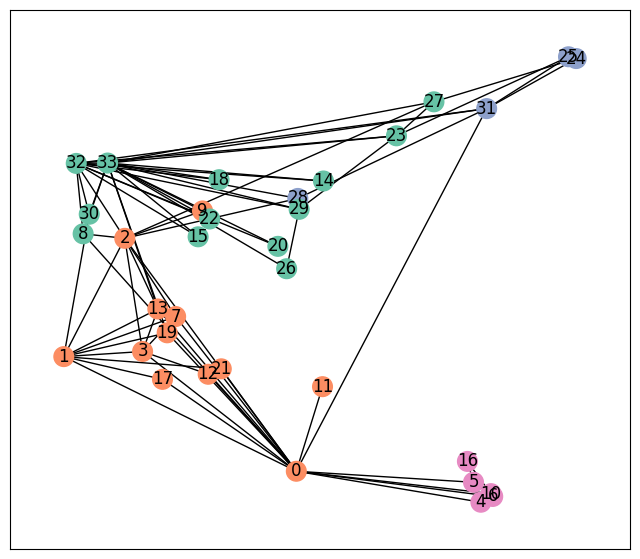

Epoch: 400 
 Train loss: 0.19257155060768127


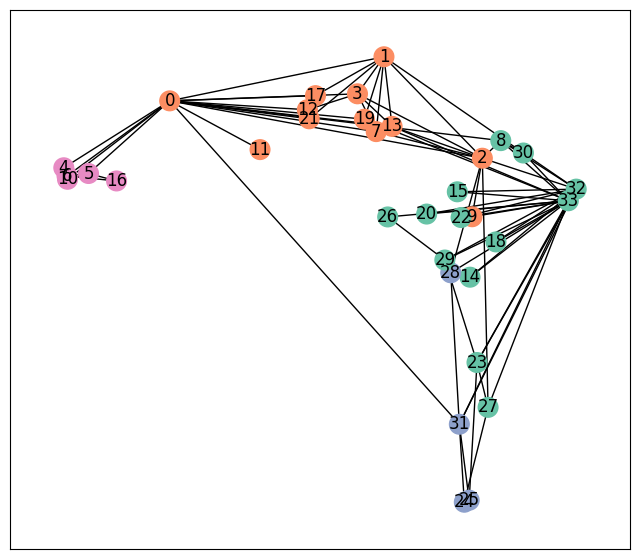

Epoch: 500 
 Train loss: 0.11848773062229156


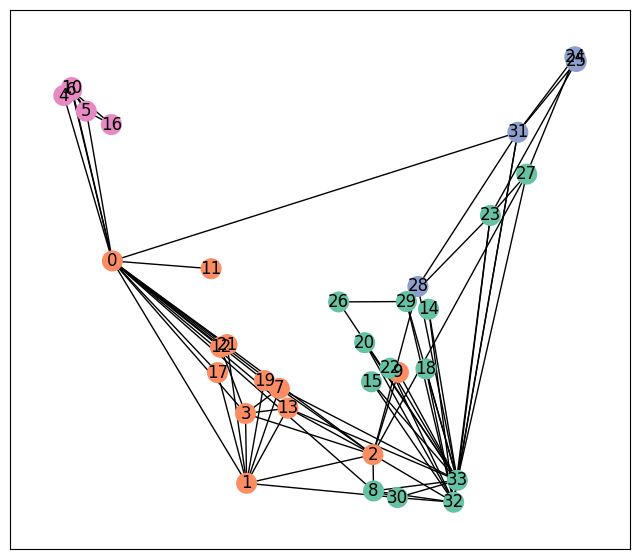

CPU times: user 2.19 s, sys: 842 ms, total: 3.03 s
Wall time: 1.59 s


In [18]:
criterion = nn.CrossEntropyLoss()
lr=0.1
optimizer = optim.SGD(net.parameters(), lr=lr)

def train(epoche,
          data,
          with_labels=True,
          node_size=200,
          edge_color='k',
          width=1.0,
          val = False
          ):
    unique_classes = list(set(data.y.tolist()))
    colormap = plt.colormaps.get_cmap('Set2')
    class_to_color = {cls: colormap(i) for i, cls in enumerate(unique_classes)}
    node_colors = [class_to_color[int(data.y[i].item())] for i in range(data.num_nodes)]
    nxg = to_networkx(data, to_undirected=True)

    optimizer.state_dict()['state'] = {}

    data = data.to(device)
    for i in range(epoche):
        net.train() # 訓練フェーズ
        optimizer.zero_grad()
        out, emb = net(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        if val:
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            net.eval()
            with torch.no_grad():
                if val:
                    print(f'Epoch: {i+1} \n Train loss: {loss}, Val loss: {val_loss}')
                else:
                    print(f'Epoch: {i+1} \n Train loss: {loss}')
                emb = net(data)[1].cpu().numpy()
                tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate="auto")
                emb_tsne = tsne.fit_transform(emb)
                fig, ax = plt.subplots(figsize=(8, 7))
                nx.draw_networkx(nxg, ax=ax, pos=emb_tsne, node_color=node_colors, with_labels=with_labels, node_size=node_size, edge_color=edge_color, width=width)
                plt.show()

%time train(500, data=data)

初期状態に比べていい感じにクラスごとに分類ができている。

## Cora データ

より大規模なデータである、Coraデータセットを使う

In [19]:
dataset = datasets.Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]

In [20]:
print(f"Dataset : {dataset}")
print("=" * 30)
print(f"グラフの数 : {len(dataset)}")
print(f"ノード特徴量の次元数 : {dataset.num_node_features}")
print(f"クラス数 : {dataset.num_classes}")
print("=" * 30)
print(data)
print(data.train_mask)
print("=" * 30)
print(f"ノードの数 : {data.num_nodes}")
print(f"エッジの数 : {data.num_edges}")
print(f"訓練に使うノードの数 : {data.train_mask.sum()}")
print(f"孤立したノードが存在するか : {data.has_isolated_nodes()}")
print(f"自己ループはあるか : {data.has_self_loops()}")
print(f"無向グラフか : {data.is_undirected()}")

Dataset : Cora()
グラフの数 : 1
ノード特徴量の次元数 : 1433
クラス数 : 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor([ True,  True,  True,  ..., False, False, False])
ノードの数 : 2708
エッジの数 : 10556
訓練に使うノードの数 : 140
孤立したノードが存在するか : False
自己ループはあるか : False
無向グラフか : True


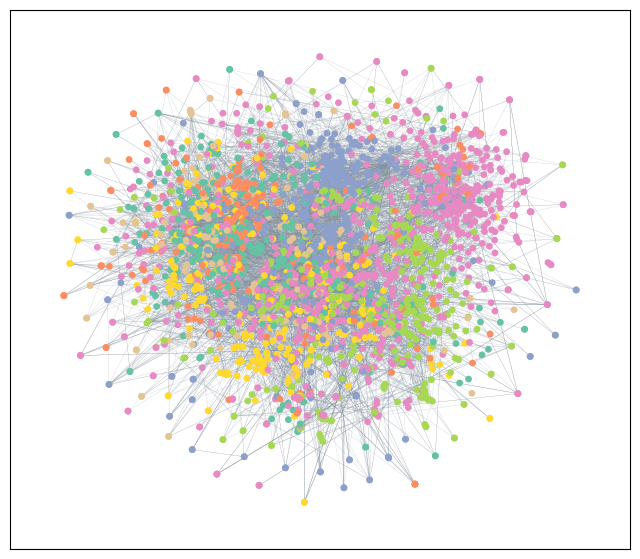

In [21]:
visualize_graph(data, with_labels=False, node_size=15, edge_color='#84919e', width=0.1)

同じモデルで学習を行う。 

In [22]:
in_d = dataset.num_node_features
out_d = dataset.num_classes

net = GCN(in_d, 512, out_d).to(device)
print(net)

GCN(
  (conv1): GCNConv(1433, 512)
  (conv2): GCNConv(512, 7)
)


Epoch: 100 
 Train loss: 0.9782312512397766, Val loss: 1.3415683507919312


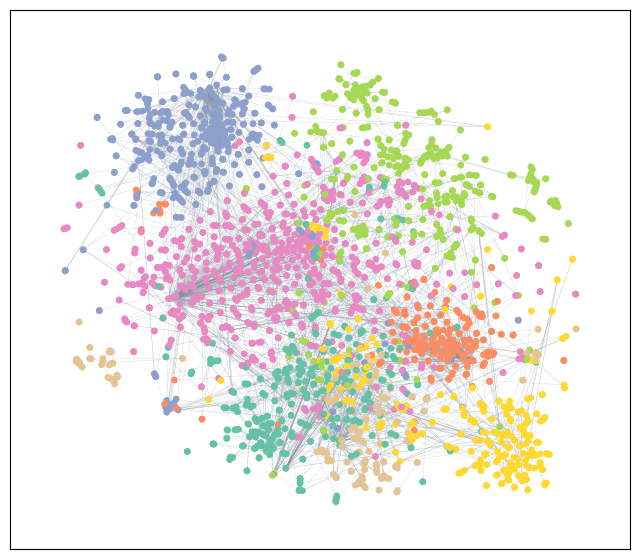

Epoch: 200 
 Train loss: 0.3927437961101532, Val loss: 0.8754404783248901


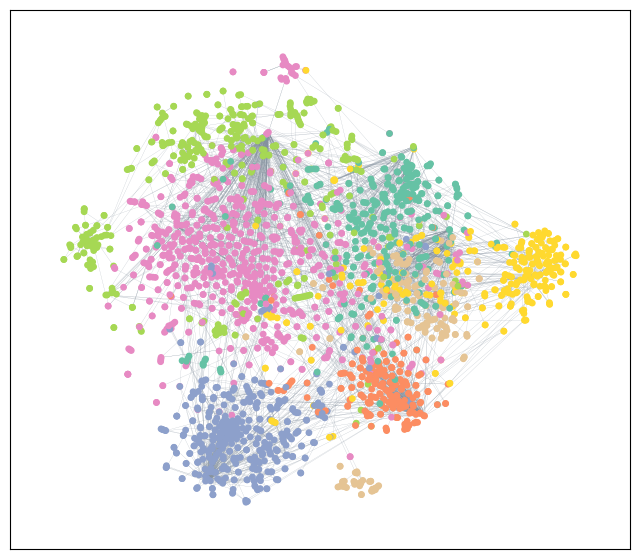

Epoch: 300 
 Train loss: 0.20702864229679108, Val loss: 0.7380070090293884


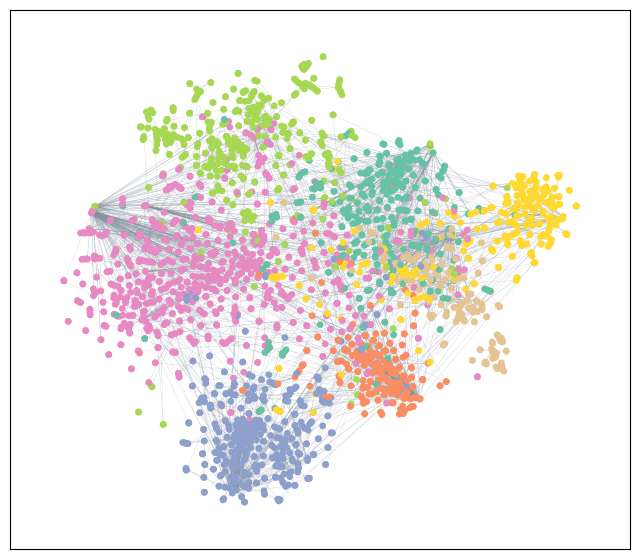

Epoch: 400 
 Train loss: 0.12770409882068634, Val loss: 0.6906531453132629


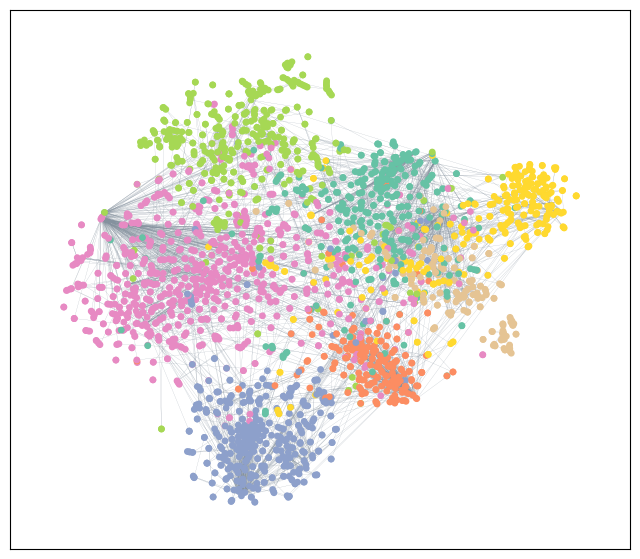

Epoch: 500 
 Train loss: 0.08726723492145538, Val loss: 0.6731151342391968


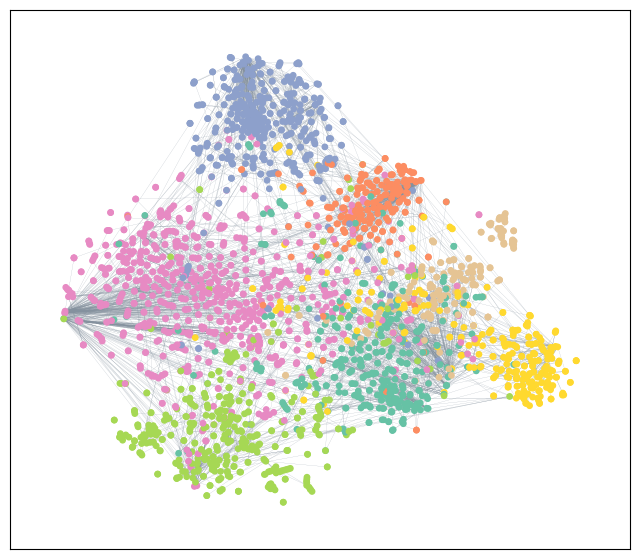

CPU times: user 1min 6s, sys: 8.76 s, total: 1min 15s
Wall time: 59.6 s


In [23]:
criterion = nn.CrossEntropyLoss()
lr=0.1
optimizer = optim.SGD(net.parameters(), lr=lr)

%time train(500, data=data, with_labels=False, node_size=15, edge_color='#84919e', width=0.1, val=True)

# レイヤークラス定義

本章では、PyG のレイヤークラスを使用せずレイヤークラスの定義から実装を行う。 \
PyG の公式リファレンス（https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv ）を確認すると必要な引数は以下である。 \
・in_channels : 入力次元 \
・out_channels : 出力次元 \
・improved : $\tilde{A}$ を $A + 2I$ で計算(default: False) \
・cached : よくわからん。 \
・add_self_loops : 自己ループの追加(default: None)。 normalize が True の時は、自動的に True に設定される。\
・normalize : 正規化の実施(default: True)。すでに正規化されている場合は False に設定。 \
・bias : バイアス項の追加(default: True)。 \
\
今回は、(in_channels, out_channels, add_self_loops, normalize, bias) を実装する。 \
また、行列形式で実装を行う。

## PyTorchベース

なるべく、PyGのモジュールを使用せずに GCN を実装する。

In [24]:
from torch.nn import Parameter
import torch.nn.init as init
from torch import Tensor
from torch_geometric.typing import Adj

class GCNlayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        add_self_loops: Optional[bool] = None,
        normalize: bool = True,
        bias: bool = True
        ):

        super().__init__()
        if add_self_loops is None:
            add_self_loops = normalize

        if add_self_loops and not normalize:
            raise ValueError(f"Cannot add self-loops without normalizing the adjacency matrix. Please enable normalization or disable self-loops.")

        if not add_self_loops and not normalize:
            raise ValueError(f"今回はエッジの重みを持ったグラフは考慮しない。")

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.add_self_loops = add_self_loops
        self.normalize = normalize
        self.bias = bias

        # 学習パラメータの作成
        self.W = nn.Parameter(torch.empty(self.in_channels, self.out_channels))
        if self.bias:
            self.b = Parameter(torch.empty(self.out_channels))

        # パラメータの初期化
        self.reset_parameters()

    # 初期化関数
    def reset_parameters(self):
        init.xavier_uniform_(self.W)  # Xavier初期化
        if self.bias:
            init.zeros_(self.b)

    # このクラスの情報を表示する関数
    def __repr__(self):
        return f'GCNlayer(in_channels={self.in_channels}, out_channels={self.out_channels}, add_self_loops={self.add_self_loops}, normalize={self.normalize}, bias={self.bias})'

    def forward(self,
                x: Tensor,
                edge_index: Adj
                ):

        # 正規化をする場合
        if self.normalize:
            # ノード数を求める
            num_nodes = x.shape[0]
            # 隣接行列を作る
            A = torch.zeros((num_nodes, num_nodes)).to(device)
            A[edge_index[0], edge_index[1]] = 1

            # 自己ループを追加する場合
            if self.add_self_loops:
                # 単位行列を作る
                I = torch.eye(num_nodes).to(device)
                # 自己ループ持ち隣接行列を作る
                A_tilde = A + I
            # 自己ループを追加しない場合
            else:
                A_tilde = A

            # 次数行列の逆行列の平方根を作る
            degrees = A_tilde.sum(dim=1) ** -0.5
            D_squ_inv = torch.diag(degrees)
            # 正規化隣接行列の計算
            A_hat = D_squ_inv @ A_tilde @ D_squ_inv

        # 正規化 & 自己ループの追加をしない場合（今回は考慮せず。そもそもインスタンス作成時にvalueエラーが起きるようになっている。）
        else:
            pass

        # 学習
        H_new = A_hat @ x @ self.W
        if self.bias:
            H_new = H_new + self.b

        return H_new

In [25]:
# グラフ畳み込みネットワークの定義
class GCN(torch.nn.Module):
    def __init__(self, in_d, mid_d, out_d):
        super().__init__()
        # 必要引数は Conv2d と一緒。入力次元(チャネル)と出力次元。
        # karateデータは自己ループがないので追加。normalize=True によってデフォルト設定で自己ループがないときは自動的に追加される
        self.conv1 = GCNlayer(in_d, mid_d)
        self.conv2 = GCNlayer(mid_d, out_d)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index # PyTorch と異なり、ノードデータとエッジデータを取得する

        x = self.conv1(x, edge_index)
        emb = x.detach()
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return x, emb

GCN(
  (conv1): GCNlayer(in_channels=1433, out_channels=512, add_self_loops=True, normalize=True, bias=True)
  (conv2): GCNlayer(in_channels=512, out_channels=7, add_self_loops=True, normalize=True, bias=True)
)


Epoch: 100 
 Train loss: 0.9659172296524048, Val loss: 1.3350412845611572


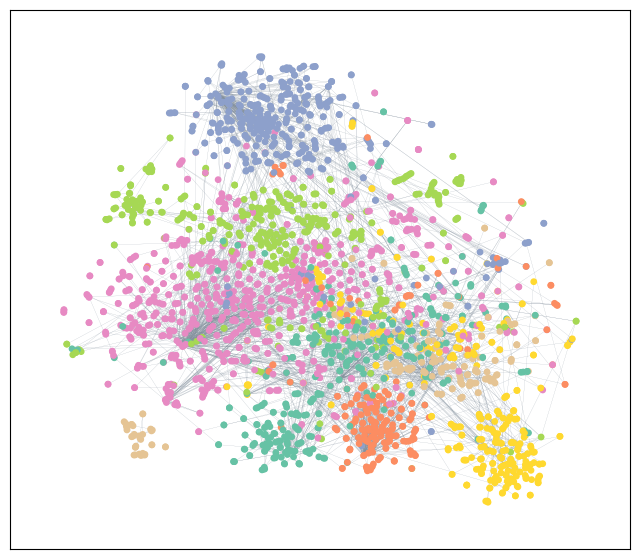

Epoch: 200 
 Train loss: 0.391720712184906, Val loss: 0.8697001934051514


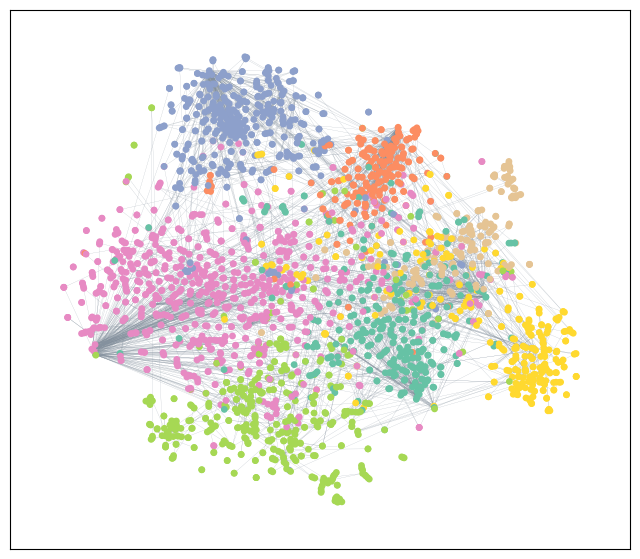

Epoch: 300 
 Train loss: 0.20861031115055084, Val loss: 0.7318750023841858


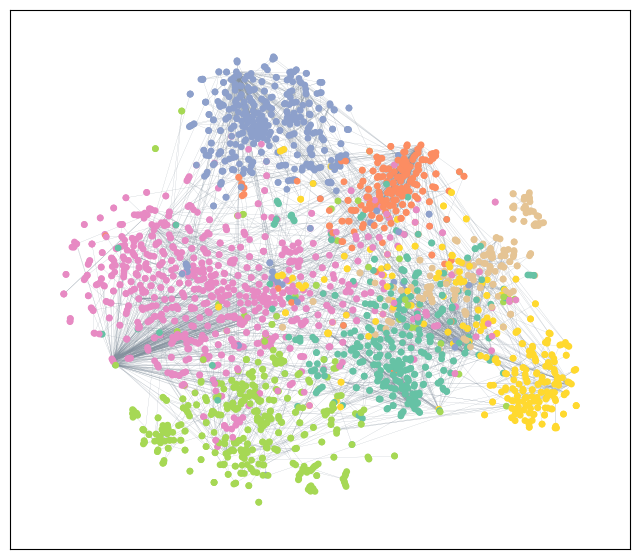

Epoch: 400 
 Train loss: 0.12929822504520416, Val loss: 0.6831140518188477


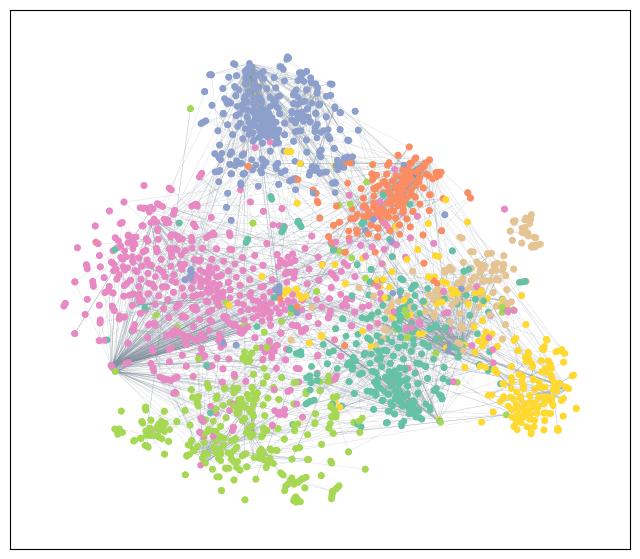

Epoch: 500 
 Train loss: 0.08844964951276779, Val loss: 0.6642798781394958


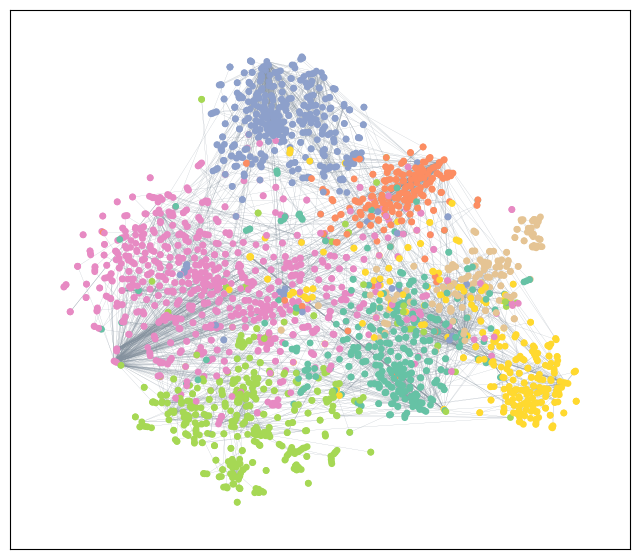

CPU times: user 4min 38s, sys: 9.82 s, total: 4min 47s
Wall time: 1min 34s


In [26]:
dataset = datasets.Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]
in_d = dataset.num_node_features
out_d = dataset.num_classes

net = GCN(in_d, 512, out_d).to(device)
print(net)
criterion = nn.CrossEntropyLoss()
lr=0.1
optimizer = optim.SGD(net.parameters(), lr=lr)

%time train(500, data=data, with_labels=False, node_size=15, edge_color='#84919e', width=0.1, val=True)

## PyGベース

前節では、 torch.nn.module を継承して GCNlayer を定義した。 \
今回は、PyG のメッセージ伝播用のモジュール torch_geometric.nn.MessagePassing を継承して GCNlayer を定義していく。 \
MessagePassing ではスカラー形式の式で実装されるので、DAD の計算を事前に計算するのではなく、各エッジに対応する正規化係数を使ってメッセージを伝搬。 \
各エッジに対応する正規化係数とはスカラー形式の式の分数の部分。

In [36]:
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNlayer(MessagePassing):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        add_self_loops: Optional[bool] = None,
        normalize: bool = True,
        bias: bool = True
        ):

        super().__init__(aggr='add') # 近傍ノードの集約方法の指定。GCN の場合は add（数式のシグマの部分）。
        if add_self_loops is None:
            add_self_loops = normalize

        if add_self_loops and not normalize:
            raise ValueError(f"Cannot add self-loops without normalizing the adjacency matrix. Please enable normalization or disable self-loops.")

        if not add_self_loops and not normalize:
            raise ValueError(f"今回はエッジの重みを持ったグラフは考慮しない。")

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.add_self_loops = add_self_loops
        self.normalize = normalize
        self.bias = bias

        # 学習パラメータの作成
        self.lin = Linear(in_channels, out_channels, bias=False) # X @ W を行う。これは、PyG でなくともできる。
        if self.bias:
            self.b = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        if self.bias:
            self.b.data.zero_()

    # このクラスの情報を表示する関数
    def __repr__(self):
        return f'GCNlayer(in_channels={self.in_channels}, out_channels={self.out_channels}, add_self_loops={self.add_self_loops}, normalize={self.normalize}, bias={self.bias})'

    def forward(self,
                x: Tensor,
                edge_index: Adj
                ):

        # 正規化、自己ループの追加を行う場合
        if self.normalize:
            # 自己ループの追加
            if self.add_self_loops:
                edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
            # 正規化の実施
            row, col = edge_index # >> edge_index(2 * n) を　始点ノード(1 * n), 終点ノード(1 * n) に分ける。
            deg = degree(col, x.size(0), dtype=x.dtype) # >> 各ノードの次数を格納したテンソルベクトルそ作成。
            deg_inv_sqrt = deg.pow(-0.5) # >> 各ノードの次数の逆平方根が格納されたテンソルベクトル
            deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0 # >> もし、無限があれば0に変換
            norm = deg_inv_sqrt[row] * deg_inv_sqrt[col] # >> エッジに対応するノードの逆平方根同士を掛けて、各エッジの正規化係数を計算

            # 集約
            x = self.lin(x)
            out = self.propagate(edge_index, x=x, norm=norm)
            if self.bias:
                out = out + self.b

        else:
            pass

        return out

    # 隣接ノードへの情報の伝播の式（今回は、スカラー形式の式のシグマを外した式。x_jはすでにWによって線形変換が行われている。）
    # propagate 内で動作
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j # \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} * Wx

In [37]:
# グラフ畳み込みネットワークの定義
class GCN(torch.nn.Module):
    def __init__(self, in_d, mid_d, out_d):
        super().__init__()
        # 必要引数は Conv2d と一緒。入力次元(チャネル)と出力次元。
        # karateデータは自己ループがないので追加。normalize=True によってデフォルト設定で自己ループがないときは自動的に追加される
        self.conv1 = GCNlayer(in_d, mid_d)
        self.conv2 = GCNlayer(mid_d, out_d)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index # PyTorch と異なり、ノードデータとエッジデータを取得する

        x = self.conv1(x, edge_index)
        emb = x.detach()
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return x, emb

GCN(
  (conv1): GCNlayer(in_channels=1433, out_channels=512, add_self_loops=True, normalize=True, bias=True)
  (conv2): GCNlayer(in_channels=512, out_channels=7, add_self_loops=True, normalize=True, bias=True)
)
Epoch: 100 
 Train loss: 1.6494663953781128, Val loss: 1.789158582687378


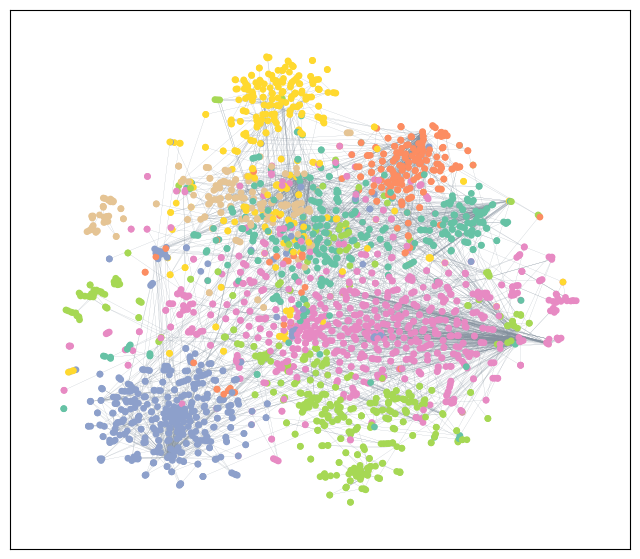

Epoch: 200 
 Train loss: 0.8146139979362488, Val loss: 1.210447072982788


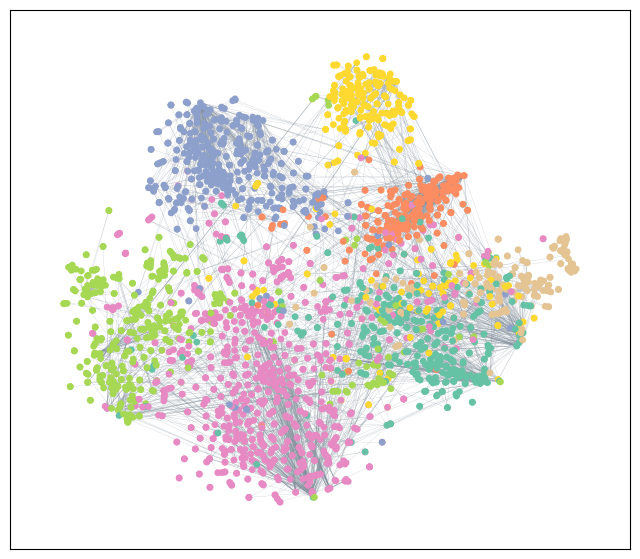

Epoch: 300 
 Train loss: 0.3726683557033539, Val loss: 0.8503686189651489


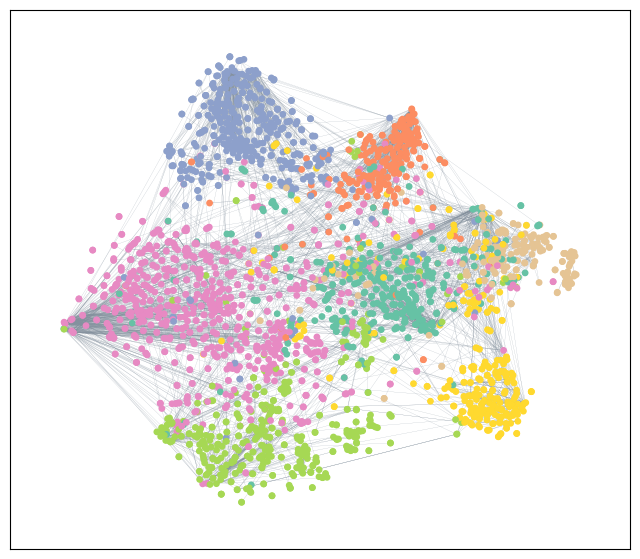

Epoch: 400 
 Train loss: 0.20865710079669952, Val loss: 0.7330612540245056


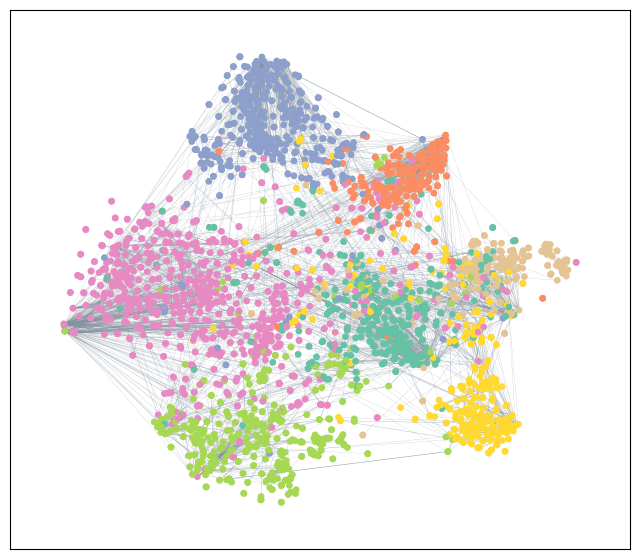

Epoch: 500 
 Train loss: 0.13257737457752228, Val loss: 0.6905072927474976


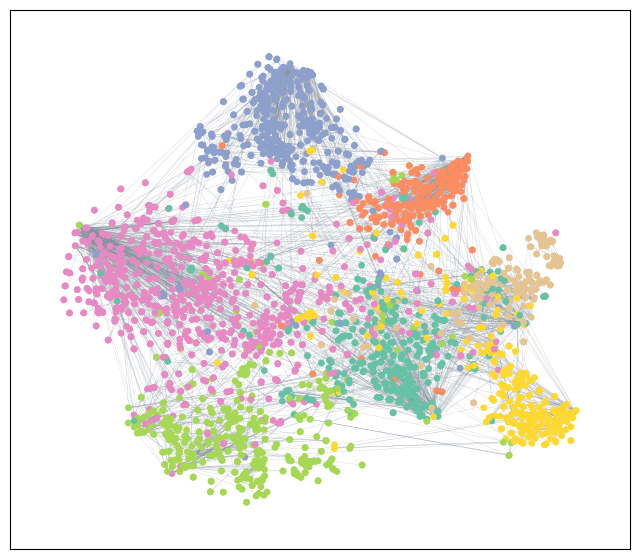

CPU times: user 1min 10s, sys: 12.7 s, total: 1min 23s
Wall time: 59.2 s


In [38]:
dataset = datasets.Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]
in_d = dataset.num_node_features
out_d = dataset.num_classes

net = GCN(in_d, 512, out_d).to(device)
print(net)
criterion = nn.CrossEntropyLoss()
lr=0.1
optimizer = optim.SGD(net.parameters(), lr=lr)

%time train(500, data=data, with_labels=False, node_size=15, edge_color='#84919e', width=0.1, val=True)